<a href="https://colab.research.google.com/github/ddamarisr/Optimizacion/blob/main/CNS_OT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Detecting Central Nervous System Oxygen Toxicity (CNS-OT) Based on Time-Domain Measures and the Time-Varying Spectral Analysis of EDA (TVSymp)

## Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [ ]:
import numpy as np
import scipy.io
import scipy.signal
import matplotlib.pyplot as plt
import imblearn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from tensorflow.keras.backend import clear_session
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib.ticker import MaxNLocator
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

## Introduction


Hyperbaric oxygen (HBO2) pre-breathing is used to mitigate decompression sickness in divers. Breathing HBO2 exacerbates the risk of developing central nervous system oxygen toxicity (CNS-OT), the symptoms of which can potentially impair performance or cause more serious reactions such as seizures, which can lead to drowning.

In this project, we built a Deep Learning (DL) model that should be capable of identifying manifestations of CNS-OT based on time-domain measures, and the time-varying spectral analysis of EDA (TVSymp) obtained from subjects exposed to HBO2.

## Data Characterization


Let's load the data we are going to work with:

In [ ]:
data = scipy.io.loadmat('/content/drive/MyDrive/Beyond Research Final/KetOxData.mat')

In our data we are going to have to deal with three types of subjects:

- **DEFINITE:** subject who developed clear symptoms of CNS-OT in the last five minutes of the experiment.
    
- **PROBABLE:** subject who developed mild symptoms of CNS-OT in the last five minutes of the experiment.
    
- **NO SYMPTOMS:** subject who didn't develop any symptoms for the duration of the experiment.

Let's see how many subjects we have for each class

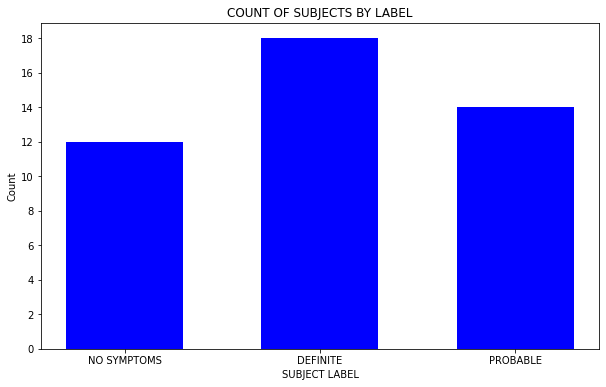

In [ ]:
nSubjects = len(data['KetOxStruct']['subject'][0][0][0])
classesOfInterest = ['DEFINITE', 'PROBABLE', 'NO SYMPTOMS']
l = []

for i in range(nSubjects):
    subjectData = list(data['KetOxStruct']['subject'][0][0][0][i])
    subjectClass = subjectData[0][0]
    
    if subjectClass in classesOfInterest:
        l.append(subjectClass)
        
d = Counter(l)

labels = list(d.keys())
values = list(d.values())
  
ax = plt.figure(figsize = (10, 6)).gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
 
plt.bar(labels, values, color ='blue', width = 0.6)
 
plt.xlabel("SUBJECT LABEL")
plt.ylabel("Count")
plt.title("COUNT OF SUBJECTS BY LABEL")
plt.show()

We have N = 44 subjects in total. 12 labeled as 'NO SYMPTOMS', 18 labeled as 'DEFINITE' and 14 labeled as 'PROBABLE'.

Now let's talk about the signals we are going to work with. For every subject, we worked with the data from four signals, namely: phEDA, TVSymp, ECG and HR.

- **phEDA**: electrodermal activity (EDA) refers to the variation of the electrical properties of the skin in response to sweat secretion [1]. Phasic skin conductance measurements are typically associated with short-term events and occur in the presence of discrete environmental stimuli - sight, sound, smell, cognitive processes that precede an event such as anticipation, decision making, etc [2]. phEDA sampling frequency is 8Hz.


- **TVSymp**: is an index of sympathetic control derived from components of phEDA, it is highly sensitive to orthostatic, cognitive, and physical stress [3]. This signal is sampled at 2Hz.


- **ECG**: a measure of heart's electrical activity. ECG is sampled at 100Hz.


- **HR**: number of heart beats per unit of time. HR is sampled at 2Hz.


Let's plot such signals for a random subject:

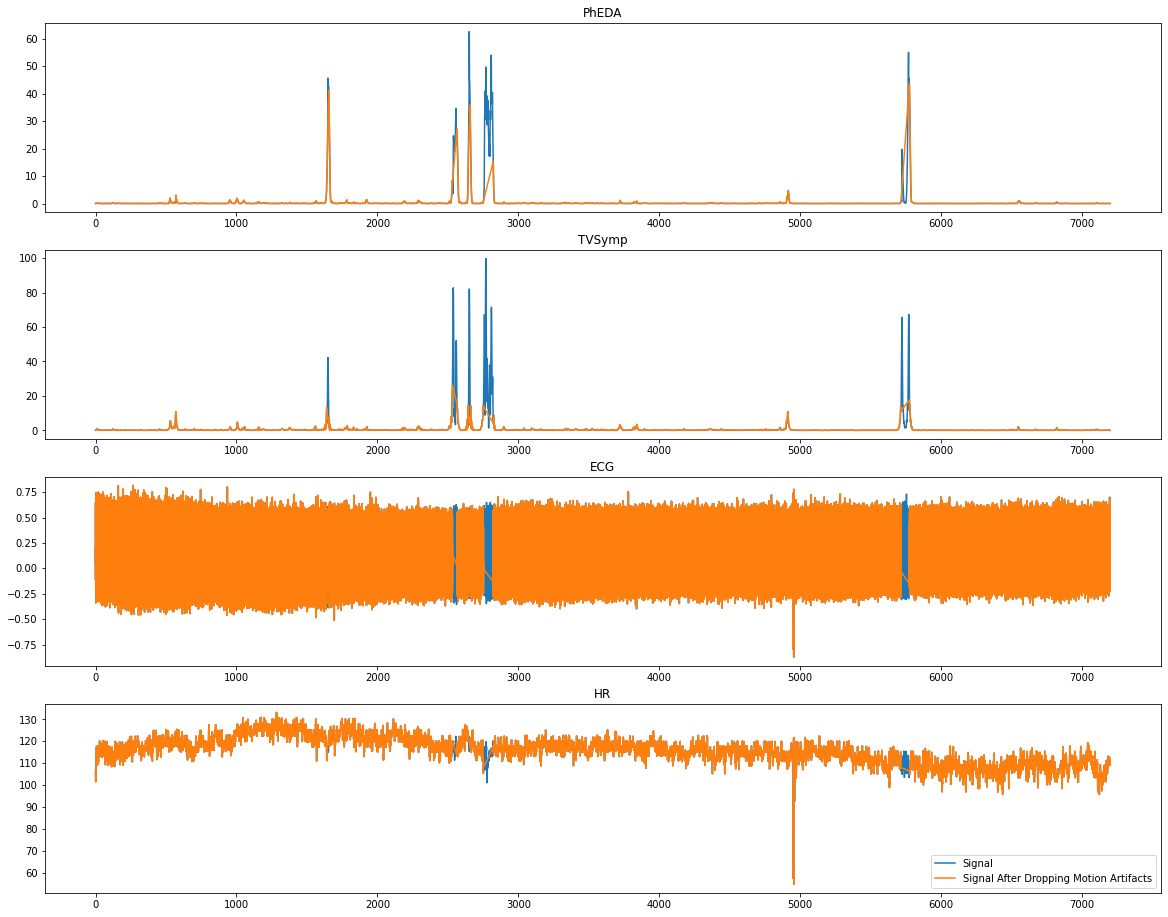

In [ ]:
sIndex = 0
subjectData = list(data['KetOxStruct']['subject'][0][0][0][sIndex])
subjectSignals = subjectData[1 : ]
signalsIndexes = [1, 5, 7, 8]

fig, axs = plt.subplots(len(signalsIndexes))
fig.set_figwidth(20)
fig.set_figheight(16)

for i in range(len(signalsIndexes)):
    Signal = subjectSignals[signalsIndexes[i]]
    time = Signal['time'][0][0][0].ravel()
    signal = Signal['signal'][0][0].ravel()
    index_valid = Signal['index_valid'][0][0][0].astype(bool)
    axs[i].plot(time, signal)
    axs[i].plot(time[index_valid], signal[index_valid])

axs[0].title.set_text('PhEDA')
axs[1].title.set_text('TVSymp')
axs[2].title.set_text('ECG')
axs[3].title.set_text('HR')

plt.legend(["Signal", "Signal After Dropping Motion Artifacts"], loc ="lower right")
plt.show()

## Data Pre-processing

We have four raw signals per subject, but we still need to perform some signal processing and subsequently transform them into features that can feed a model.

### Signal Preparation

**1. Removing Motion Artifacts**: Even though signals were recorded in a controlled lab environment, sudden movement of a subject during the experiment could lead to erroneous signal readings (artifacts). The good news is that the provided data also marked each sample as either valid or invalid, so it wasn't difficult to filter out the invalid samples.

**2. Signal Resampling**: As per the Data Characterization section, signals are originally sampled at distinct frequencies. We needed to resample all signals so that all of them had the same number of samples. Our strategy in this case was to resample everything to the highest frequency among the frequencies of the four signals. Using upsampling instead of downsampling was important to not loose information after performing this process.

**3. Splitting Signals in Fragments**: After steps 2 and 3 every signal was partitioned into 10 second fragments called windows. This was done in order to facilitate the creation of the model's features.

### Inputs

The input of the model consists of an array of ten-second fragments of raw signal data corresponding to the same interval of time and coming from the same subject. Clearly, the task of our model will be to classify such an array of signal fragments either as class one (manifestation of symptoms of CNS-OT) or class zero.

### Examples

Having established what the inputs of the model look like, we now need to build the examples that we will use to train the model. For that, for every subject, we label the arrays of ten-second fragments of signals corresponding to the same interval of time as follows:

![](https://drive.google.com/uc?export=view&id=1Q3uc_sSe1aQlxNErs7UdvPjPveSWK03c)

- If the subject is labeled as either **DEFINITE** or **PROBABLE**:
    - If every window in an array of signal fragments lies in the last five minutes of the recorded time, i.e. in the red stripe on the figure, then the array is going to be labeled as an example of class one or CNS-OT symptoms class.
    - If every window in an array of signal fragments lies in the five minutes prior to the final five minutes, i.e. in the gray stripe on the figure, then the example is going to be ignored.
    - If every window in an array of signal fragments lies anywhere else i.e. in the green stripe on the figure, then the example is going to be labeled as class zero or no symptoms class.
- If the subject is labeled as **NO SYMPTOMS**:
    - For the time being we are not going to include examples derived from subjects of this class.

### Code

Here's the code that makes the data ready for training

In [ ]:
'''
CNS-OT symptoms dataset. 

available signals = {...
    'EDA',...
    'phEDAcvx',...
    'dphEDAcvx',...
    'sdphEDAcvx',...
    'phdriverEDAcvx',...
    'TVSymp','MTVSymp',...
    'ECG','HR',...
    };
    phEDA --> 8HZ
    TVSymp --> 2HZ
    HR --> 2Hz
    ECG --> 100Hz
'''

def prepareData(acceptedClasses, acceptedSignals, symptomsTime = 300, windowTime = 10):
    
    def forwardFill(signal, validIndexes):
        filledSignal = np.zeros(len(signal))
        lastValidVal = signal[0]

        for i in range(len(signal)):
            if validIndexes[i]:
                filledSignal[i], lastValidVal = signal[i], signal[i]
            else:
                filledSignal[i] = lastValidVal

        return filledSignal
    
    def prepareSignal(signal, validIndexes, targetLength):
        filledSignal = forwardFill(signal, validIndexes)
        resampledSignal = scipy.signal.resample(filledSignal, targetLength)

        return resampledSignal[:targetLength]

    def sliceData(signalFragments, windowLength):
        slices = []

        for i in range(0, len(signalFragments[0]) - windowLength + 1, windowLength):
            slices.append([s[i : i + windowLength] for s in signalFragments])
                
        return np.array(slices)
    
    nSubjects = len(data['KetOxStruct']['subject'][0][0][0])
    finalData = []
    
    for i in range(nSubjects):
        subjectData = list(data['KetOxStruct']['subject'][0][0][0][i])
        subjectClass = subjectData[0][0]
        
        if subjectClass not in acceptedClasses:
            continue

        subjectSignals = subjectData[1 : ]
        
        signalValues = []
        signalIndexes = []
        signalTimes = []
        
        for k in acceptedSignals:
            signalValues.append(subjectSignals[k]['signal'][0][0].ravel())
            signalIndexes.append(subjectSignals[k]['index_valid'][0][0][0].astype(bool))
            signalTimes.append(subjectSignals[k]['time'][0][0][0].ravel())
                                        
        targetLength = max([len(s) for s in signalValues])
        
        preparedSignals = [prepareSignal(signalValues[i], signalIndexes[i], targetLength) 
                            for i in range(len(signalValues))]
        
        preparedSignals.append(i)
                
        finalData.append(preparedSignals)
    
    signalsFreq = round(targetLength / (signalTimes[0][-1] - signalTimes[0][0]))
    
    symptomsAreaLength = signalsFreq * symptomsTime
    windowLength = signalsFreq * windowTime

    X, y, G = [], [], []
    
    for t in finalData:
        symptomsAreaFragments = [s[-symptomsAreaLength:] for s in t[:-1]]
        symptomsAreaWindows = sliceData(symptomsAreaFragments, windowLength)
        
        noSymptomsAreaFragments = [s[:-2*symptomsAreaLength] for s in t[:-1]]
        noSymptomsAreaWindows = sliceData(noSymptomsAreaFragments, windowLength)
        
        X.extend(symptomsAreaWindows)
        y.extend([1] * len(symptomsAreaWindows))
        X.extend(noSymptomsAreaWindows)
        y.extend([0] * len(noSymptomsAreaWindows))
        G.extend([t[-1]] * (len(symptomsAreaWindows) + len(noSymptomsAreaWindows)))
        
    return (X, y, G)

## Model Training

We employed a Leave-One-Out Cross Validation strategy for training the model. That basically means that we trained N models, each one with examples from N - 1 subjects and after training is done, we tested each one of those N models with data belonging to the one subject that was left out of the training set. This has to be done in this way since we want to make sure that the testing data is unknown to the model.

![](https://drive.google.com/uc?export=view&id=1Av8cuyxnCtxdCMFrSq9h59i9g8Ao-EiI)

### Class Imbalance in Training Set

We already know how many examples of **DEFINITE** or **PROBABLE** subjects are there, but we haven't checked how many examples of the class one and of the zero class we have in our training set. Let's do it now.

In [ ]:
acceptedClasses = ['DEFINITE', 'PROBABLE']
acceptedSignals = [1, 5, 7, 8]
X, y, G = prepareData(acceptedClasses, acceptedSignals)

class_one_size = len([x for x in y if x == 1])
class_zero_size = len(y) - class_one_size
class_one_fraction = 100 * class_one_size / (class_one_size + class_zero_size)
class_zero_fraction = 100 * class_zero_size / (class_one_size + class_zero_size)

print('AMOUNT EXAMPLES CLASS ONE:', class_one_size)
print('AMOUNT EXAMPLES CLASS ZERO:', class_zero_size)
print('FRACTION EXAMPLES CLASS ONE:', f"{class_one_fraction:.2f}%") 
print('FRACTION EXAMPLES CLASS ZERO:', f"{class_zero_fraction:.2f}%")

AMOUNT EXAMPLES CLASS ONE: 960
AMOUNT EXAMPLES CLASS ZERO: 8552
FRACTION EXAMPLES CLASS ONE: 10.09%
FRACTION EXAMPLES CLASS ZERO: 89.91%


Unsurprisingly, the zero class is way overrepresented when compared to the one class. We need to try to balance the classes before training the model, or else it will perform poorly in the classification of the examples of the minority class, which happens to be the one of our greatest interest.

We came up with two complementary approaches to achieve a balanced dataset: downsampling the zero class and oversampling the one class.

#### Downsampling the Zero Class

We introduce the Downsampling Factor $\text{DF}$ of the zero class as another parameter of our model, $\text{DF}$ is an integer with $0 \le \text{DF} \le 100$.  Then we establish the following equality:

$$\lvert \text{downsampled zero class}\rvert = \lvert \text{zero class} \rvert + \text{DF} \ (\lvert \text{one class} \rvert - \lvert \text{zero class}\rvert)$$

We have that $\lvert \text{one class} \rvert \le \lvert \text{downsampled zero class} \rvert \le \lvert \text{zero class} \rvert$, so we can select the examples for the downsampled zero class by selecting $\lvert \text{downsampled zero class}\rvert$ examples uniformly at random from the always bigger zero class.

#### Upsampling the One Class

At this point $\lvert \text{one class} \rvert < \lvert \text{downsampled zero class}\rvert$ if $\text{DF} < 100$. In that case we still need to increase the count of examples for the one class.

For that end we used a synthetic oversampling technique called SMOTE. With SMOTE we were able to increase the number of examples for the positive class by producing additional synthetic examples. This is how with SMOTE’s help we were able to obtain a oversampled positive class consisting of both actual and synthetic examples, such oversampled class was meant to have the same count of examples as the downsampled negative class.

$$\lvert \text{oversampled one class} \rvert = \lvert \text{downsampled zero class} \rvert$$

Clearly it is necessary to find the $\text{DF}$ value that yields the best results, for this purpose we used a range search approach by testing the $\text{DF}$ values from $0$ to $100$ with an increment of $10$.

### Model Architecture

The built model is a shallow LSTM (Long short-term memory) network. We used this kind of networks since they have shown robust classification performance on multidimensional time series data [1]. The model was implemented with code written by us in Python (version 3.0) and Keras with Tensorflow Backend.

All networks were trained for $200$ epochs. We employed a learning rate of $0.001$, and Adam optimizer with a binary cross-entropy loss function.

![](https://drive.google.com/uc?export=view&id=1-1FE4_4wyFug3_zGu-ZpqK-FCCQAMOi1)

### Code

Here's the code that trains the network:

In [ ]:
def trainModel(X, y, G, downsampleFactor):
    
    print("TRAINING-----------------------------------------", downsampleFactor)
    
    def downsampleZeroClass(X, y, G, downsampleFactor):
        Xd, yd = [], []
        zeroClassExs = []
        oneClassExs = []
        i, j = 0, 0
        downsampleRate = downsampleFactor / 100
        np.random.seed(0)

        while(i < len(X)):

            while(j < len(X) and G[i] == G[j]):
                zeroClassExs.append(X[j]) if y[j] == 0 else oneClassExs.append(X[j])
                j += 1

            classDiff = len(zeroClassExs) - len(oneClassExs)
            selectionSize = int(len(zeroClassExs) - (downsampleRate * classDiff))

            selectedExsZeroClassIndexes = np.random.choice(len(zeroClassExs), size = selectionSize, replace = False)
            selectedExsZeroClass = [zeroClassExs[i] for i in selectedExsZeroClassIndexes]

            Xd.extend(oneClassExs)
            yd.extend([1] * len(oneClassExs))
            Xd.extend(selectedExsZeroClass)
            yd.extend([0] * len(selectedExsZeroClass))

            zeroClassExs.clear()
            oneClassExs.clear()
            
            i = j

        return (Xd, yd)
    
    
    def upsampleOneClass(X, y):
        oversample = SMOTE()
        
        signalAmount = len(X[0])
        signalLength = len(X[0][0])
        
        Xr = np.reshape(X, (len(X), signalAmount * signalLength)) # We need to concatenate all signals
        Xo, yo = oversample.fit_resample(Xr, y)
        Xo = np.reshape(Xo, (len(Xo), signalAmount, signalLength)) # We restore X's original dimensions
        
        return (Xo, yo)
        
    def buildModel():
        model = Sequential()
        model.add(LSTM(10, dropout = 0.5, recurrent_dropout = 0.5))
        model.add(Dense(10))
        model.add(Dropout(0.7))
        model.add(Dense(1, activation='sigmoid'))
        optimizer = Adam(learning_rate=0.001)
        model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[Recall(), Precision()])

        return model
    
    logo = LeaveOneGroupOut()
    scores = []

    for train_index, test_index in logo.split(X, y, G):
        clear_session()

        X_train, X_test = [X[i] for i in train_index], [X[i] for i in test_index]
        y_train, y_test = [y[i] for i in train_index], [y[i] for i in test_index]
        G_train = [G[i] for i in train_index]
        
        Xd, yd  = downsampleZeroClass(X_train, y_train, G_train, downsampleFactor)
        Xu, yu = upsampleOneClass(Xd, yd)

        X_train, y_train = shuffle(Xu, yu, random_state = 0)
        X_train, y_train = np.array(X_train), np.array(y_train)
        
        X_test, y_test = shuffle(X_test, y_test, random_state = 0)
        X_test, y_test = np.array(X_test), np.array(y_test)

        model = buildModel()
        
        model.fit(X_train, y_train, epochs=200, batch_size=1024)
        
        scores.append(model.evaluate(X_test, y_test, verbose = 0))
    
    return scores

## Results

### Metrics

$$\text{TP} = \text{True Positives} \qquad \text{FP} = \text{False Positives} \qquad \text{FN} = \text{False Negatives}$$

</br>

- **Recall**: A measure of how many examples of class one were identified by the model, for the evaluation of our model, we will place special emphasis on this metric.

</br>

$$\text{RECALL} = \dfrac{\text{TP}}{\text{TP} + \text{FN}}$$

</br>

- **Precision**: A measure of how many examples identified as class one by the model, are actually class one.

</br>

$$\text{PRECISION} = \dfrac{\text{TP}}{\text{TP} + \text{FP}}$$

</br>

- **F1-score**: The harmonic mean of Precision and Recall.

</br>

$$\text{F1-score} = \dfrac{2 \times \text{PRECISION} \times \text{RECALL}}{\text{PRECISION} + \text{RECALL}}$$

### Baseline Model

This might be the first model that has ever been built to identify CNS-OT symptoms from signals collected far away from the brain. So we cannot rely on the existing literature to get an idea of how our model is performing comparatively speaking.

In order to overcome this, we used a "dummy" model that classifies every example as class zero or class one with a probability of 50% each, as our baseline model. This allows us to compare the results of our model with those of a model that makes predictions without taking into account the data.

In [ ]:
dummy_clf = DummyClassifier(strategy='uniform')
Xs, ys = shuffle(X, y, random_state = 0)
dummy_clf.fit(Xs, ys)
y_pred = dummy_clf.predict(Xs)
baseline_recall = recall_score(ys, y_pred)
baseline_precision = precision_score(ys, y_pred)
baseline_f1 = f1_score(ys, y_pred)

print('DUMMY MODEL RECALL SCORE:', f"{baseline_recall:.2f}")
print('DUMMY MODEL PRECISION SCORE:', f"{baseline_precision:.2f}")
print('DUMMY MODEL F1 SCORE:', f"{baseline_f1:.2f}")

DUMMY MODEL RECALL SCORE: 0.50
DUMMY MODEL PRECISION SCORE: 0.10
DUMMY MODEL F1 SCORE: 0.17


### Results

In [ ]:
def plot_bar_graph(labels, values, title, ylabel = 'Recall'):
    ax = plt.figure(figsize = (14, 8))
    plt.title(title)
    plt.ylim(0 , 1)
    plt.grid(axis = 'y')
    plt.yticks(np.arange(0, 1.1, 0.2))
    plt.bar(labels, values, color ='blue', width = 0.6)
    plt.ylabel(ylabel)
    plt.show()

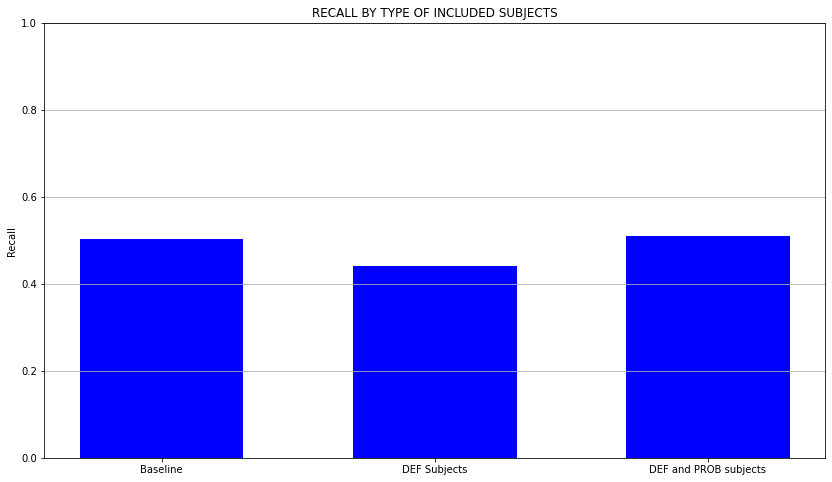

In [ ]:
labels = ['Baseline', 'DEF Subjects', 'DEF and PROB subjects']
values = [baseline_recall, 0.44, 0.51]
title = 'RECALL BY TYPE OF INCLUDED SUBJECTS'
  
plot_bar_graph(labels, values, title)

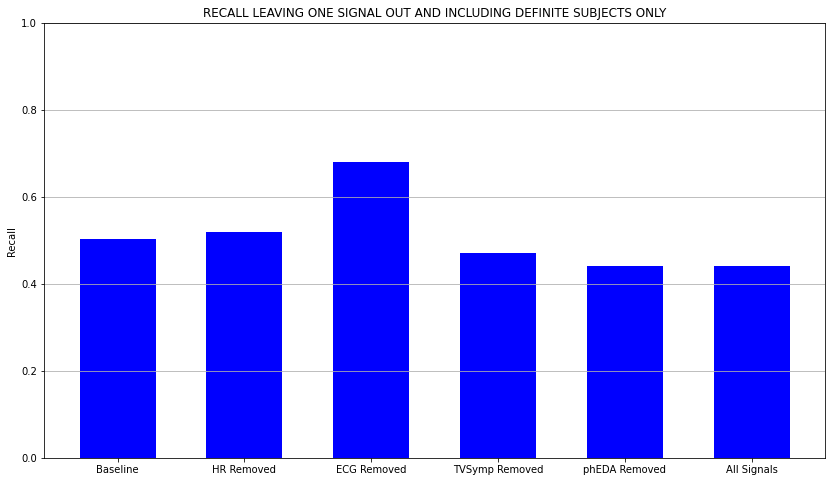

In [ ]:
labels = ['Baseline', 'HR Removed', 'ECG Removed', 'TVSymp Removed', 'phEDA Removed', 'All Signals']
values = [baseline_recall, 0.52, 0.68, 0.47, 0.44, 0.44]
title = 'RECALL LEAVING ONE SIGNAL OUT AND INCLUDING DEFINITE SUBJECTS ONLY'

plot_bar_graph(labels, values, title)

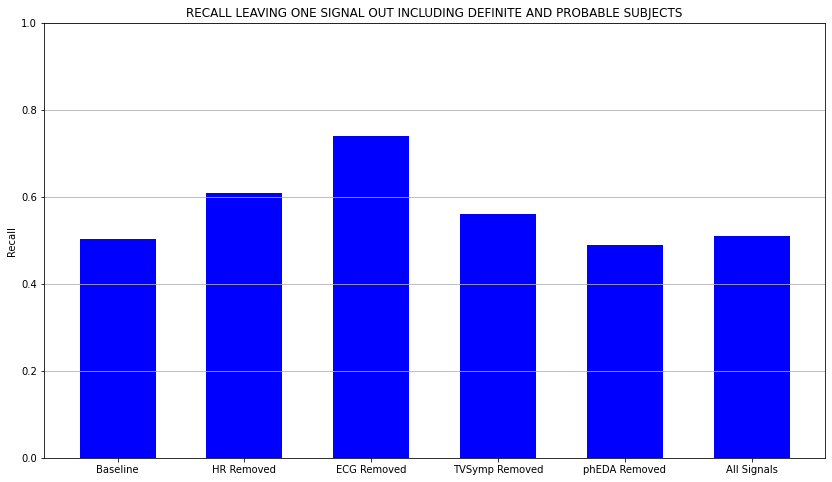

In [ ]:
labels = ['Baseline', 'HR Removed', 'ECG Removed', 'TVSymp Removed', 'phEDA Removed', 'All Signals']
values = [baseline_recall, 0.61, 0.74, 0.56, 0.49, 0.51]
title = 'RECALL LEAVING ONE SIGNAL OUT INCLUDING DEFINITE AND PROBABLE SUBJECTS'
  
plot_bar_graph(labels, values, title)

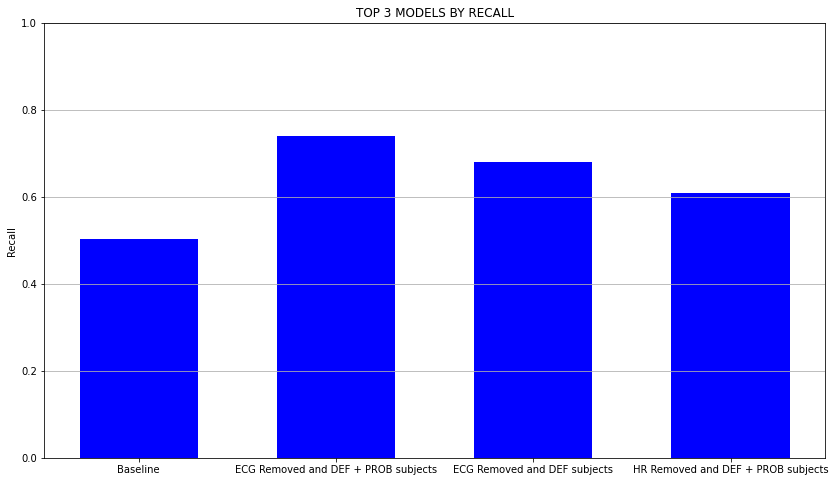

In [ ]:
labels = ['Baseline', 'ECG Removed and DEF + PROB subjects', 'ECG Removed and DEF subjects', 'HR Removed and DEF + PROB subjects']
values = [baseline_recall, 0.74, 0.68, 0.61]
title = 'TOP 3 MODELS BY RECALL'
  
plot_bar_graph(labels, values, title)

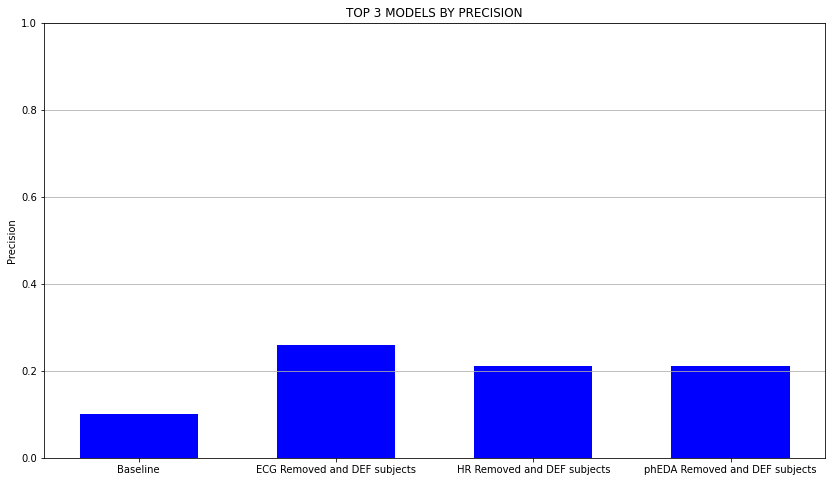

In [ ]:
labels = ['Baseline', 'ECG Removed and DEF subjects', 'HR Removed and DEF subjects', 'phEDA Removed and DEF subjects']
values = [baseline_precision, 0.26, 0.21, 0.21]
title = 'TOP 3 MODELS BY PRECISION'
  
plot_bar_graph(labels, values, title, 'Precision')

### Results Table

![](https://drive.google.com/uc?export=view&id=1YRzDM-jsLXUj6tVfcG-G1qe2bp4EVRE1)

## Discussion

- Most models performed better than the baseline model. The best performing model yielded a 0.24 improvement over the baseline model in terms of recall.

- Using ECG hurt model’s performance. This is probably because SMOTE was not very effective when oversampling long features when fed with a "reduced" number of examples.

- We can clearly see that feeding the model with data from more subjects has an appreciable (positive) impact on model’s performance.

- The results demonstrate that there is a signature of CNS-OT symptoms manifested in the analyzed signals. Said signature might not be detected by visual inspection but it's being picked by our models.

- Our work also evidences that this signature can be learned across subjects and therefore is not subject-specific.

- Even though every model reported a better precision than the baseline model, more possibilities need to be explored in order to bring this indicator to a more acceptable level.

## Conclusions

- It’s crucial to have basic notions of signal processing specially for the data preparation stage e. g. do not downsample signals to a freq lower than the Nyquist freq.

- Raw metrics are important, but when state of the art is unknown, it’s important to have a baseline model to get a sense of how a model is performing from a comparative point of view.

- Performing an analysis of the contribution of the individual signals was fundamental, because that allowed us to discover that the ECG signal was somehow hurting the performance of the model.

- Our work shows that it is possible to build a model that identifies CNS-OT episodes from signals captured away from the brain, this is a fundamental first step that encourages us to continue working towards the goal of integrating a system that should be able to identify such symptoms in real time, or even to predict them.

## References

[1] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2892750/

[2] https://support.empatica.com/hc/en-us/articles/203621955-What-should-I-know-to-use-EDA-data-in-my-experiment-

[3] https://pubmed.ncbi.nlm.nih.gov/27440716/